Vector Embeddings of Pretrained Model https://huggingface.co/fse/word2vec-google-news-300

In [1]:
import torch

In [2]:
inputId = torch.tensor([2,3,5,1])

In [6]:
vocabSize = 6
vectorDim = 3

torch.manual_seed(123) # Seed makes randomness repeatable.
embedding = torch.nn.Embedding(vocabSize, vectorDim) # Creates a Lookup Table

In [7]:
print(embedding.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [10]:
print(embedding(torch.tensor([5])))

tensor([[-2.8400, -0.7849, -1.4096]], grad_fn=<EmbeddingBackward0>)


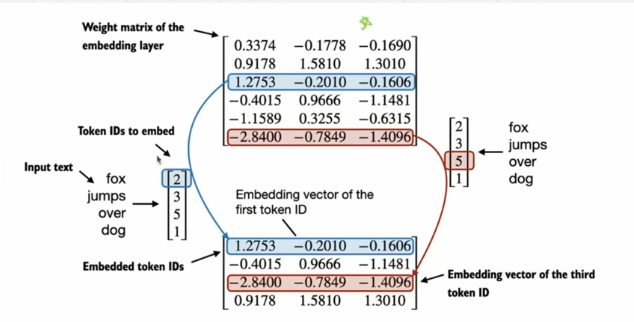

# Positional Encoding/Embedding
1) Absolute Positional Embedding
2) Relative Positional Embedding

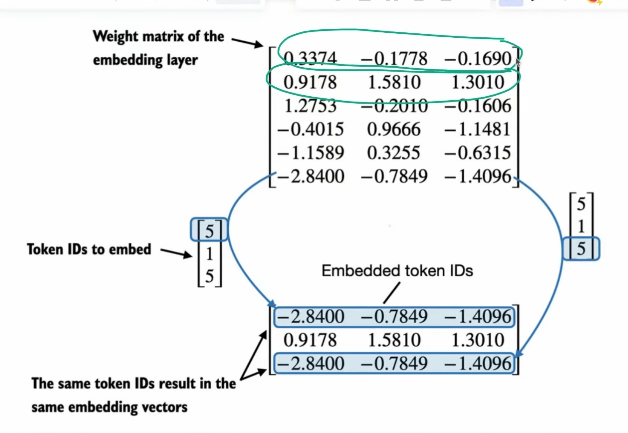

In [42]:
vocab_size = 50257
vector_dim = 256

embedingLayer = torch.nn.Embedding(vocab_size, vector_dim)
print(embedingLayer.weight)

Parameter containing:
tensor([[ 0.2413, -0.7418, -0.6052,  ...,  0.8580, -0.1300, -0.2224],
        [ 0.9027, -0.8100, -0.8962,  ..., -1.0623, -0.7779, -0.1262],
        [ 0.4083,  0.6583, -1.3363,  ...,  1.5649,  0.3597,  0.0842],
        ...,
        [-2.1400, -2.5262,  1.4213,  ..., -1.1446,  2.2331, -1.3071],
        [ 0.2795, -1.1833, -0.0892,  ...,  0.4960,  0.8412,  0.0323],
        [-0.4270, -2.8876, -1.3638,  ..., -0.4342, -0.1795,  1.0636]],
       requires_grad=True)


1) Getting Ip data from data  loader
batch size of 8 and context length of 4

In [28]:
!pip install tiktoken

In [32]:
import importlib
import tiktoken


In [34]:
with open("the-verdict.txt", "r", encoding = "utf-8") as f:
  rawText = f.read()
print(len(rawText))

20479


In [33]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, maxLen, stride):
    self.ipIds = []
    self.targetIds = []

    # S1 --> Tokenize the Entire text
    tokenIds = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

    # S2 --> Using sliding window to chunk book into overlapping sequence of maxLen
    for i in range(0, len(tokenIds) - maxLen, stride):
      inputChunk = tokenIds[i:i+maxLen]  # 0->4
      targetChunk = tokenIds[i+1:i+1+maxLen] # 1->5

      self.ipIds.append(torch.tensor(inputChunk))  # Input Tensor X
      self.targetIds.append(torch.tensor(targetChunk)) # Target Tensor Y

  def __len__(self):
    return len(self.ipIds)
  def __getitem__(self, idx):
    return self.ipIds[idx], self.targetIds[idx]  # Ip OP Pairs

In [35]:
def dataLoaderV1(txt, batch_size = 4, max_length = 256,
                 stride = 128, shuffle = True, drop_last = True,
                 num_workers = 0):
  # S1) Initialize the tokenizer
  tokenizer = tiktoken.get_encoding("gpt2")
  # S2) Create Dataset
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  # S3) Create Dataloader
  dataloader = DataLoader(dataset, batch_size = batch_size,
                          shuffle = shuffle, drop_last = drop_last,
                          num_workers = num_workers)
  return dataloader


In [37]:
max_length = 4
dataloader = dataLoaderV1(rawText, max_length = max_length, batch_size=8,
                          stride = max_length, shuffle = False
)
dataIter = iter(dataloader)
inputs, target = next(dataIter)

In [38]:
print("Token ID's: ", inputs)
print("Inputs shape:", inputs.shape)

Token ID's:  tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Inputs shape: torch.Size([8, 4])


2) Now One embedding vector of length 256 is generated for each token in input

In [43]:
tokenEmbeddings = embedingLayer(inputs)
print(tokenEmbeddings.shape)

torch.Size([8, 4, 256])


In [51]:
contextLen = max_length
positionalEmbeddingLayer = torch.nn.Embedding(contextLen, vector_dim) # 4X256

In [52]:
positionalEmbeddings = positionalEmbeddingLayer(torch.arange(contextLen))
print(positionalEmbeddings.shape) # 4 vectors of 256 dimension

torch.Size([4, 256])


Adding Token Embeddings(8x4x256)+Positional Embeddings(4x256)
= Input Embeddings(8x4x256)